In [13]:
#Importing Datasets
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

test.shape

(1459, 80)

In [14]:
# Calculate the number of rows with missing values
rows_with_missing_values = test.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {rows_with_missing_values}")

# Calculate the number of missing values by column
missing_values_by_column = test.isnull().sum()
print("Missing values by column:")
for column, missing_values in missing_values_by_column.items():
    if missing_values != 0:
        print(f"{column}: {missing_values}")

Number of rows with missing values: 1459
Missing values by column:
MSZoning: 4
LotFrontage: 227
Alley: 1352
Utilities: 2
Exterior1st: 1
Exterior2nd: 1
MasVnrType: 16
MasVnrArea: 15
BsmtQual: 44
BsmtCond: 45
BsmtExposure: 44
BsmtFinType1: 42
BsmtFinSF1: 1
BsmtFinType2: 42
BsmtFinSF2: 1
BsmtUnfSF: 1
TotalBsmtSF: 1
BsmtFullBath: 2
BsmtHalfBath: 2
KitchenQual: 1
Functional: 2
FireplaceQu: 730
GarageType: 76
GarageYrBlt: 78
GarageFinish: 78
GarageCars: 1
GarageArea: 1
GarageQual: 78
GarageCond: 78
PoolQC: 1456
Fence: 1169
MiscFeature: 1408
SaleType: 1


Each row, 1459, has a missing value.

Columns to remove due to lack of data:
* FireplaceQu: 730 = 50% missing
* PoolQC: 1456 = 99.7% missing
* Fence: 1169 = 80.1% missing
* MiscFeature: 1408 = 96.5% missing
* Alley: 1352 = 92.7% missing

Columns with significant missing data to be mapped: (N/A = 0)
* LotFrontage: 227 = 15.5% missing

Remaining:
* MSZoning: 4
* Utilities: 2
* Exterior1st: 1
* Exterior2nd: 1
* MasVnrType: 16
* MasVnrArea: 15
* BsmtQual: 44
* BsmtCond: 45
* BsmtExposure: 44
* BsmtFinType1: 42
* BsmtFinSF1: 1
* BsmtFinType2: 42
* BsmtFinSF2: 1
* BsmtUnfSF: 1
* TotalBsmtSF: 1
* BsmtFullBath: 2
* BsmtHalfBath: 2
* KitchenQual: 1
* Functional: 2
* GarageType: 76
* GarageYrBlt: 78
* GarageFinish: 78
* GarageCars: 1
* GarageArea: 1
* GarageQual: 78
* GarageCond: 78
* SaleType: 1

In [15]:
#Fixing Missing Data
from sklearn.impute import KNNImputer

#Drops columns with >= 50% missing data
colsToDrop = ['PoolQC', 'FireplaceQu', 'Fence', 'MiscFeature', 'Alley']
test = test.drop(columns = colsToDrop)
train = train.drop(columns = colsToDrop)

categorical_cols = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType',
                    'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                    'KitchenQual','Functional','GarageType','GarageFinish','GarageQual','GarageCond','SaleType', 'Electrical']

numerical_cols = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                  'BsmtFullBath','BsmtHalfBath','GarageYrBlt','GarageCars','GarageArea']

# Replace missing values in categorical columns with the mode
for col in categorical_cols:
    mode = train[col].mode()[0]
    train[col].fillna(mode, inplace=True)
    test[col].fillna(mode, inplace=True)

#Tried KNN imputer, median worked better
#knn_imputer = KNNImputer(n_neighbors=9)
#train[numerical_cols] = knn_imputer.fit_transform(train[numerical_cols])
#test[numerical_cols] = knn_imputer.transform(test[numerical_cols])

# Replace missing values in numerical columns with the median or mean, depending on your preference
for col in numerical_cols:
    median = train[col].median()
    train[col].fillna(median, inplace=True)
    test[col].fillna(median, inplace=True)
    
#LotFrontage
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [16]:
#Preprocessing data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#Features
categorical_features = ['MSZoning', 'Street', 'LotShape','LandContour','Utilities','LotConfig', 'LandSlope', 
                        'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
                        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
                        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
                        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

numeric_features = [col for col in train.columns if col not in categorical_features + ['SalePrice', 'Id']]

#Split dataset
y = train['SalePrice']

#Preprocessor function
preprocessor = ColumnTransformer(sparse_threshold = 0.0, n_jobs = -1,
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)]) #drop='first' as a param gives much worse results

#Fits preprocessor
preprocessor.fit(train)

#gets cols and combines
onehot_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features = categorical_features)
all_feature_names = numeric_features + list(onehot_columns)

#transforms datasets
train = pd.DataFrame(data= preprocessor.transform(train), columns = all_feature_names)
test = pd.DataFrame(data= preprocessor.transform(test), columns = all_feature_names)

print(test.head())

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0   -0.872563     0.645747  0.110763    -0.795151     0.381743  -0.340077   
1   -0.872563     0.674605  0.375850    -0.071836     0.381743  -0.439440   
2    0.073375     0.472599  0.332053    -0.795151    -0.517200   0.852269   
3    0.073375     0.588031 -0.054002    -0.071836     0.381743   0.885390   
4    1.492282    -0.421999 -0.552407     1.374795    -0.517200   0.686666   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0     -1.156380   -0.570750    0.053428    0.604293  ...             0.0   
1     -1.301740    0.027027    1.051363   -0.288653  ...             0.0   
2      0.636400   -0.570750    0.761852   -0.288653  ...             0.0   
3      0.636400   -0.460051    0.347326   -0.288653  ...             0.0   
4      0.345679   -0.570750   -0.396190   -0.288653  ...             0.0   

   SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0          

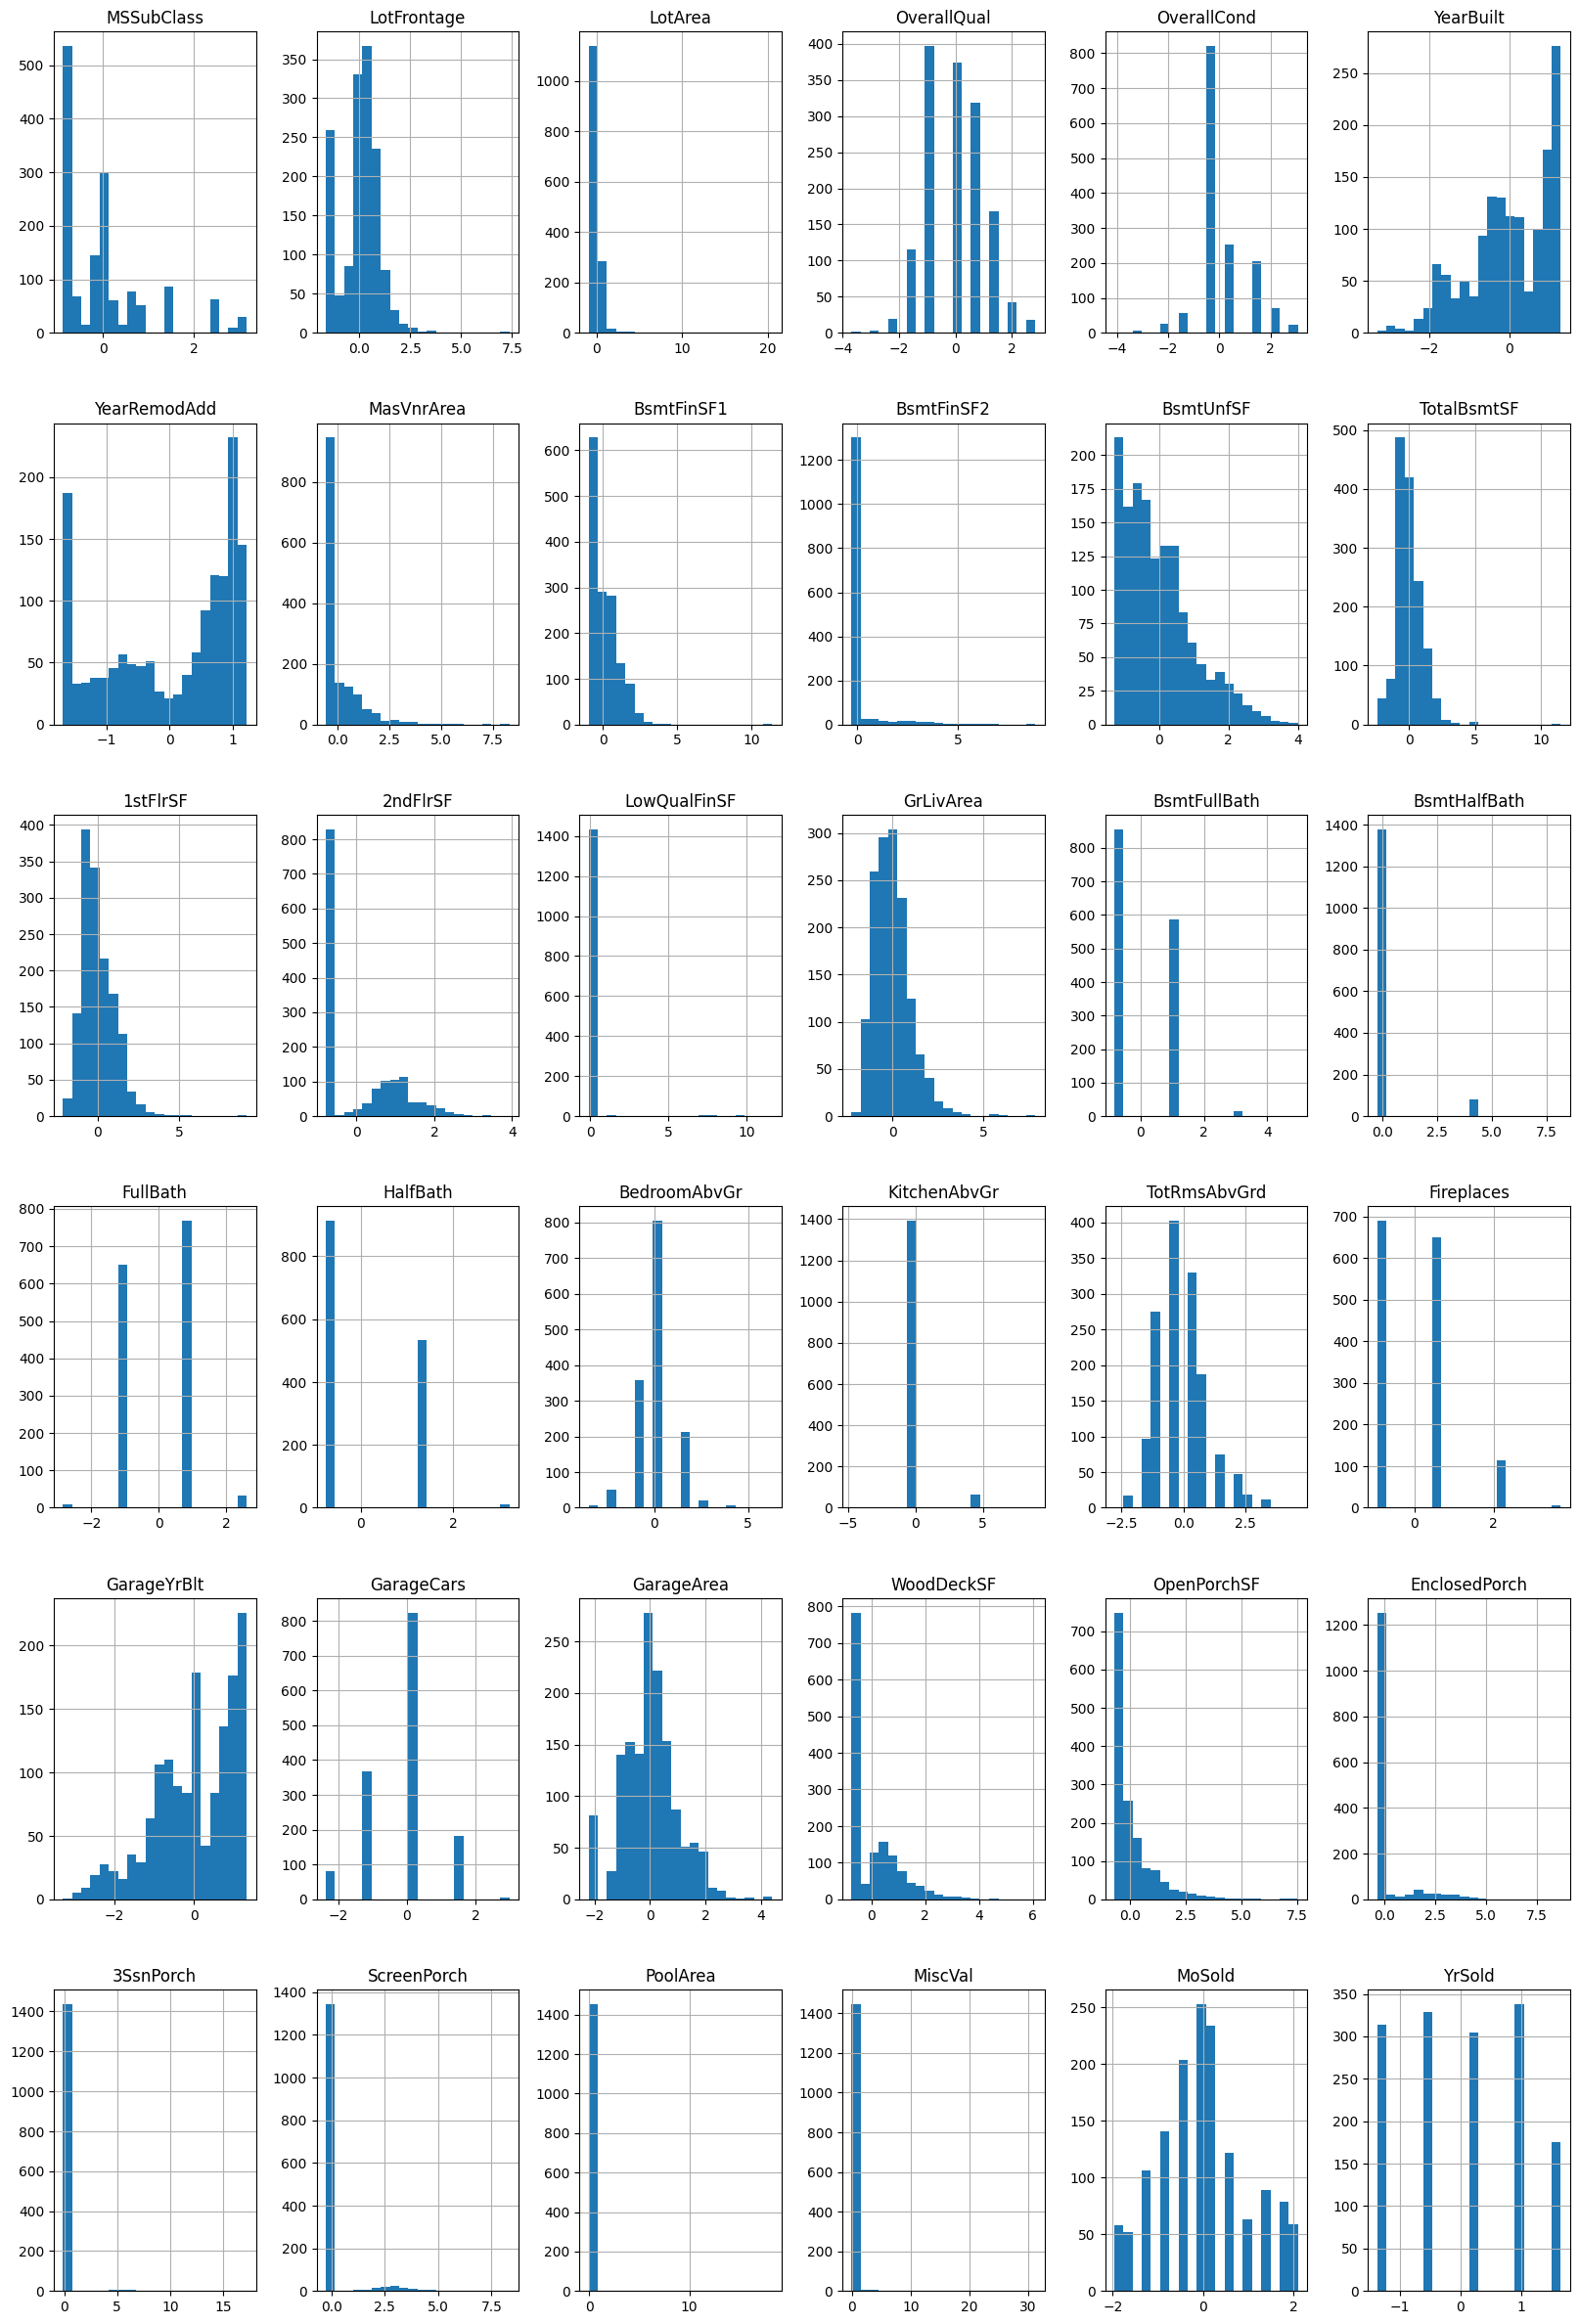

In [17]:
#Visualize Data
import matplotlib.pyplot as plt
train[numeric_features].hist(bins=20, figsize=(20, 30))

plt.show()

In [18]:
#Feature Selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (
                    train, y, test_size = .1)

# Filter: Variance Threshold
vt = VarianceThreshold(threshold = 0.1)
vt.fit(X_train)
print("Features dropped by Variance Threshold:")
print(X_train.columns[vt.get_support()])
X_train = pd.DataFrame(vt.transform(X_train))
X_test = pd.DataFrame(vt.transform(X_test))
test = pd.DataFrame(vt.transform(test))

print("\nshape after filter:", X_train.shape)

# Embedded: Elastic Net
#from sklearn.linear_model import ElasticNet
#elastic = ElasticNet()
#elastic.fit(X_train, y_train)

# Extract the coefficients from the model
#coef = elastic.coef_
#coef_series = pd.Series(coef, index = X_train.columns)

#threshold = 100
#selected_coef = coef_series[np.abs(coef_series) > threshold]
#X_train_filter = X_train
#X_train = X_train[selected_coef.index]
#X_test = X_test[selected_coef.index]
#test = test[selected_coef.index]
#dropped_features = X_train_filter.columns.difference(X_train.columns)

#print("\nFeatures dropped by Elastic Net:")
#print(X_train.columns[vt.get_support()][dropped_features])
#print("\nshape after elastic:", X_train.shape)
                            
# Feature Extraction: PCA
#from sklearn.decomposition import PCA
#pca = PCA(n_components = 40)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
#test = pca.transform(test)
#print("\nshape after pca:", X_train.shape)

Features dropped by Variance Threshold:
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1',
       'LotShape_Reg', 'LotConfig_Corner', 'LotConfig_Inside',
       'Neighborhood_NAmes', 'Condition1_Norm', 'BldgType_1Fam',
       'HouseStyle_1Story', 'HouseStyle_2Story', 'RoofStyle_Gable',
       'RoofStyle_Hip', 'Exterior1st_HdBoard', 'Exterior1st_MetalSd',
       'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior2nd_HdBoard',
       'Exterior

In [19]:
#Fit Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[100, 150, 200, 250], 'max_depth':[2, 3, 4]}

boost = GradientBoostingRegressor(learning_rate = 0.1)
grid = GridSearchCV(estimator= boost, param_grid= parameters, scoring= 'neg_root_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 3, 'n_estimators': 200}


In [20]:
#Predict
y_pred = grid.predict(X_test)

In [21]:
#Evaluation
from sklearn.metrics import r2_score, mean_squared_error

#R2 Score
print(f'R^2 Score:    {r2_score(y_test, y_pred):.3f}')

#Mean_Squared_Error <- Real Target
print(f'Mean^2 Error: {mean_squared_error(y_test, y_pred):.0f}')

R^2 Score:    0.978
Mean^2 Error: 89521426


In [22]:
#save results to a file
y_pred_final = pd.DataFrame(grid.predict(test))
y_pred_final.columns = ['SalePrice']
y_pred_final.index = y_pred_final.index + 1461
y_pred_final.index.name = 'Id'
y_pred_final.to_csv('submission.csv', index=True) 